In [1]:
import string
import tarfile

import numpy as np
import scipy
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [95]:
# Path to the tar file and the target file inside it
tar_path = 'handwritingBCIData.tar'
target_mat_path = './handwritingBCIData/Datasets/t5.2019.05.08/singleLetters.mat'

# Open the tar file
with tarfile.open(tar_path, 'r') as tar:
    # Get the file object
    mat_member = tar.getmember(target_mat_path)
    mat_file = tar.extractfile(mat_member)
    
    # Load the .mat file
    if mat_file is not None:
        data = scipy.io.loadmat(mat_file)

In [96]:
n_trials = 27
n_steps = 201 # each step is 10ms, so 201 * 10ms * 0.001ms/s ~= 2 seconds per trial
n_channels = 192

In [97]:
letterKeyFmt = "neuralActivityCube_{}"
data[letterKeyFmt.format("d")]

array([[[0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        ...,
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 2],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 1, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 1, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 1, 0, 1],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 2, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 0, 0],
        [1, 1, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0]],

       [[1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 1],
        ...,
        [0, 0, 0, ..., 

In [98]:
# Display the # of spikes detected in the 10th electrode while writing "d".
data[letterKeyFmt.format("d")][0,:,10]

array([0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 2, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 2, 0, 1, 1, 2, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1], dtype=uint8)

In [99]:
# Note: Flatten the first two dimensions (n_trials, n_steps) to treat each time window as a single sample.
# The neural activity at any given point will have # of dimensions = n_channels. We then use PCA to reduce
# this highly dimensional data to three dimensions. These three dimensions capture the most variance
# in the n_channels-dimensional data and thus can be thought of as a "good" representation of the neural
# activty at any given point in time (we can figure out what % of the total variance these three dimensions
# account for by summing the eigenvalues for the three PCs and dividing them by the sum of eigenvalues for all PCs).
reduced = PCA(n_components=3).fit_transform(data[letterKeyFmt.format("d")].reshape(-1, n_channels))

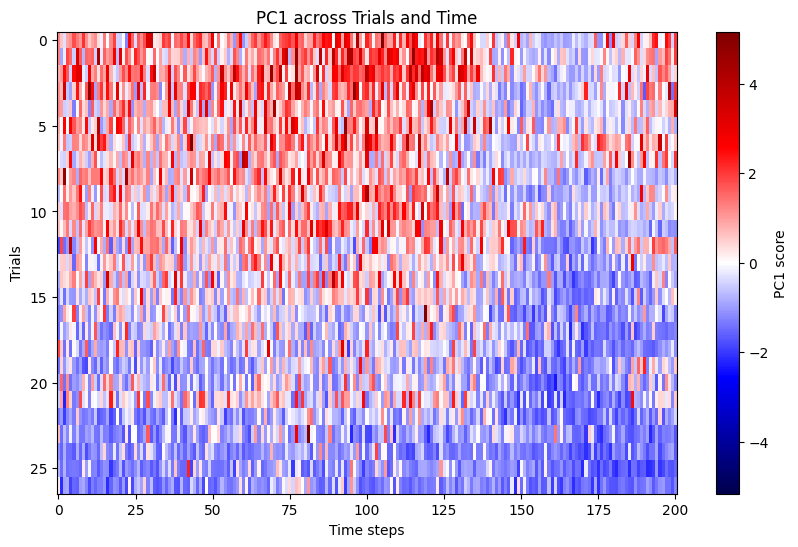

In [100]:
reduced = reduced.reshape(27, 201, 3)
pc1 = reduced[:, :, 0]

# Plot as a heatmap
plt.figure(figsize=(10, 6))
plt.imshow(pc1, aspect='auto', cmap='seismic', interpolation='nearest')
plt.colorbar(label='PC1 score')
plt.xlabel('Time steps')
plt.ylabel('Trials')
plt.title('PC1 across Trials and Time')

# Improve color mapping: make zero = white
plt.clim(-np.max(np.abs(pc1)), np.max(np.abs(pc1)))  # symmetric color limits

plt.show()

In [109]:
trialsDataForEachLetter = []
letterToIdx = dict()
for idx, char in enumerate(string.ascii_lowercase):
    letterKeyFmt = "neuralActivityCube_{}"
    letterData = data[letterKeyFmt.format(char)].copy()

    # Three trials correspond to one recording "block". We compute a blockwise z-score for each
    # threshold crossing count to normalize drift across blocks. Since base firing rates or
    # variance can drift over time for the same neurons.
    # Q: Why three trials per block? `meansPerBlock` pre-computes means for each of the 9 blocks,
    # but couldn't we also treat each trial, or >3 trials, as a block?
    # A: Looks like each block had 3 trials for each letter. i.e. write a 3 times, then b 3 times, etc.
    trialIdx = 0
    for blockIdx in range(9):
        # (trials,steps,means)
        # each element in means represents mean threshold crossing count
        # for a particular electrode across time
        # we'll then subtract this mean from the crossing counts across all time steps
        # (with the help of broadcasting along the 2nd dimension)
        means = np.zeros((3,1,n_channels))
        means[:,0,:] = data["meansPerBlock"][blockIdx,:]

        # sanity check that mean is same for the three trials
        assert np.array_equal(means[0,0,:], means[1,0,:])
        assert np.array_equal(means[0,0,:], means[2,0,:])

        std_devs = data["stdAcrossAllData"][np.newaxis,:]
        assert std_devs.shape == (1, 1, n_channels)
        assert std_devs.dtype == np.float64

        # block == 3 trials
        # (trials,steps, channels)
        letterData[trialIdx:trialIdx+3,:,:] = letterData[trialIdx:trialIdx+3,:,:] - means
        letterData[trialIdx:trialIdx+3,:,:] = letterData[trialIdx:trialIdx+3,:,:] / std_devs;
        trialIdx += 3
    trialsDataForEachLetter.append(letterData)
    letterToIdx[char] = idx
combinedTrials = np.concat(trialsDataForEachLetter, axis=0)

In [110]:
assert combinedTrials.shape == (len(string.ascii_lowercase) * n_trials, n_steps, n_channels)
combinedTrials.shape, letterToIdx

((702, 201, 192),
 {'a': 0,
  'b': 1,
  'c': 2,
  'd': 3,
  'e': 4,
  'f': 5,
  'g': 6,
  'h': 7,
  'i': 8,
  'j': 9,
  'k': 10,
  'l': 11,
  'm': 12,
  'n': 13,
  'o': 14,
  'p': 15,
  'q': 16,
  'r': 17,
  's': 18,
  't': 19,
  'u': 20,
  'v': 21,
  'w': 22,
  'x': 23,
  'y': 24,
  'z': 25})

In [111]:
# Each row is a 192D vector representing the brain state for a particular letter, trial, and time step.
combinedPCAReduced = PCA(n_components=3).fit_transform(combinedTrials.reshape(-1, n_channels))

In [112]:
# (letters, trials, steps, channels)
a = np.random.rand(*(2,3,4,5))
a_ = a.reshape(-1, 5)
assert a_.shape == (2*3*4,5)

# Checking my understanding of reshaping arrays...
# * the first 12 rows represent the flattened (trials, steps, channels) for the first letter.
# * the second 12 rows represent the data for the second letter.
assert np.array_equal(a[1], a_[12:,:].reshape(3,4,5))

In [113]:
combinedPCAReduced.shape

(141102, 3)

In [114]:
# Reshape to (letters, trials, steps, PCs).
combinedPCAReduced = combinedPCAReduced.reshape(len(string.ascii_lowercase), n_trials, n_steps, 3)

In [115]:
combinedPCAReduced.shape

(26, 27, 201, 3)

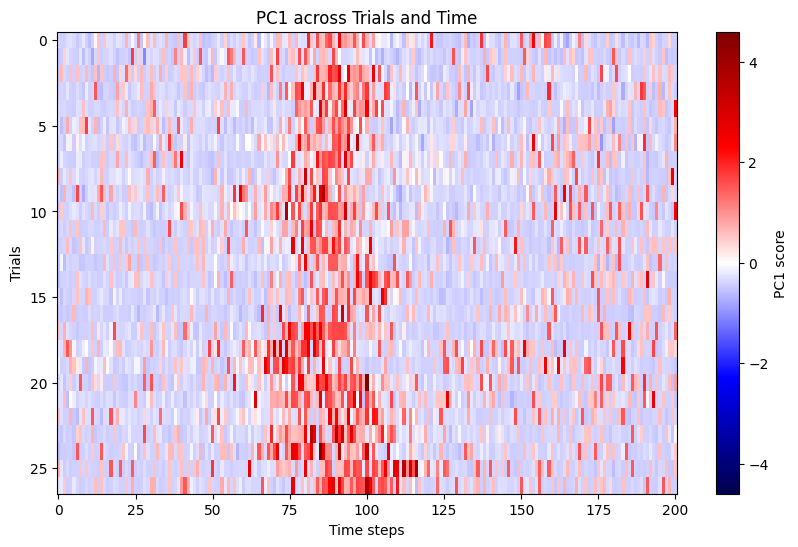

In [143]:
pc1_for_a = combinedPCAReduced[letterToIdx['f'],:,:,0]

# Plot as a heatmap
plt.figure(figsize=(10, 6))
plt.imshow(pc1_for_a, aspect='auto', cmap='seismic', interpolation='nearest')
plt.colorbar(label='PC1 score')
plt.xlabel('Time steps')
plt.ylabel('Trials')
plt.title('PC1 across Trials and Time')

# Improve color mapping: make zero = white
plt.clim(-np.max(np.abs(pc1_for_a)), np.max(np.abs(pc1_for_a)))  # symmetric color limits

plt.show()